# DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data

## Objective: 
This assignment will challenge you to apply a sophisticated, model-based approach
to tackle the class imbalance problem. You will use a Gaussian Mixture Model (GMM) to
generate synthetic samples for the minority class, and then evaluate its effectiveness compared
to a baseline model. This assignment focuses on the theoretical and practical aspects of
using probabilistic models for data augmentation.

## 1. Problem Statement
You are a data scientist tasked with building a fraud detection model for a financial institution.
You have been given a highly imbalanced dataset where a tiny fraction of transactions are
fraudulent. Your main challenge is to create a training set that allows a classifier to learn the
nuances of the minority (fraudulent) class without overfitting or misclassifying. You will
implement a GMM-based synthetic data generation pipeline and analyze its impact on model
performance.
You will submit a Jupyter Notebook with your complete code, visualizations, and a plausible
story that explain

Dataset: The dataset is available on Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

## 2. Tasks

In [ ]:
# Importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

### Part A: Baseline Model and Data Analysis  [To Borrow from A3]

Imbalance Ratio (Non-Fraud:Fraud) = 577.88:1
Class Distribution:
Non-Fraudulent transactions: 284315 (99.8273%)
Fraudulent transactions: 492 (0.1727%)


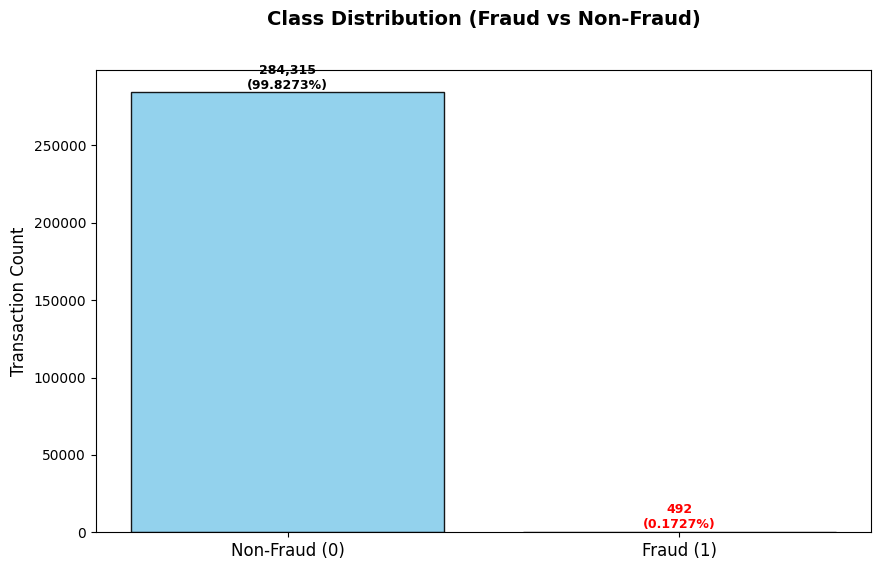

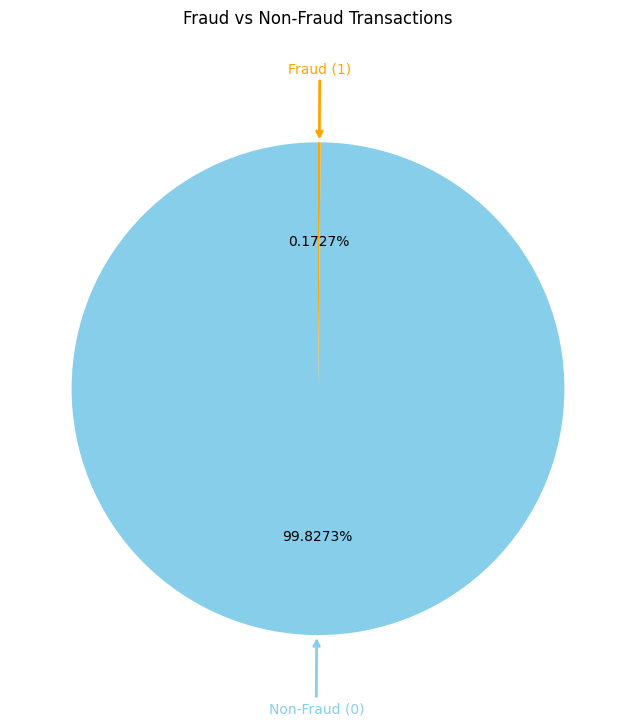

In [7]:
# 1. Data Loading and Analysis

# Load the creditcard.csv dataset
credit_card_data = pd.read_csv('creditcard.csv')

# Print the class distribution and discuss the degree of imbalance.

class_counts = credit_card_data['Class'].value_counts()
non_fraud = class_counts[0]
fraud = class_counts[1]
imbalance_ratio = non_fraud / fraud
labels = ['Non-Fraud (0)', 'Fraud (1)']
bar_colors = ['skyblue', 'red']
pie_colors = ['skyblue', 'orange']
total = len(credit_card_data)

print(f'Imbalance Ratio (Non-Fraud:Fraud) = {imbalance_ratio:.2f}:1')
print("Class Distribution:")
print(f"Non-Fraudulent transactions: {non_fraud} ({non_fraud/total*100:.4f}%)")
print(f"Fraudulent transactions: {fraud} ({fraud/total*100:.4f}%)")

plt.figure(figsize=(10,6))
bars = plt.bar(class_counts.index, class_counts.values, 
               color=bar_colors, edgecolor='black', alpha=0.9)

plt.xticks(ticks=[0,1], labels=labels, fontsize=12)
plt.ylabel("Transaction Count", fontsize=12)
plt.title("Class Distribution (Fraud vs Non-Fraud)", 
          fontsize=14, fontweight='bold', y=1.08)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = (height/total)*100
    plt.text(bar.get_x() + bar.get_width()/2, 
             height + total*0.001,
             f"{height:,}\n({pct:.4f}%)",
             ha='center', va='bottom', fontsize=9,
             color='black' if i==0 else 'red', fontweight='bold')

plt.show()


plt.figure(figsize=(8,8))
wedges, texts, autotexts = plt.pie(
    class_counts,
    autopct='%1.4f%%',
    startangle=90,
    colors=pie_colors
)

# Add labels with arrows dynamically
for i, wedge in enumerate(wedges):
    ang = (wedge.theta2 + wedge.theta1)/2.
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))

    plt.annotate(labels[i],
                 xy=(x, y), xytext=(1.3*x, 1.3*y),
                 arrowprops=dict(arrowstyle="->", 
                                 color=pie_colors[i], lw=2),
                 ha='center', va='center',
                 fontsize=10, color=pie_colors[i])

plt.title("Fraud vs Non-Fraud Transactions", y=1.08)
plt.show()

Class distribution in full dataset:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

Class distribution in training set:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

Class distribution in testing set:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9997    0.9996     56864
           1     0.8193    0.6939    0.7514        98

    accuracy                         0.9992     56962
   macro avg     0.9094    0.8468    0.8755     56962
weighted avg     0.9992    0.9992    0.9992     56962



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


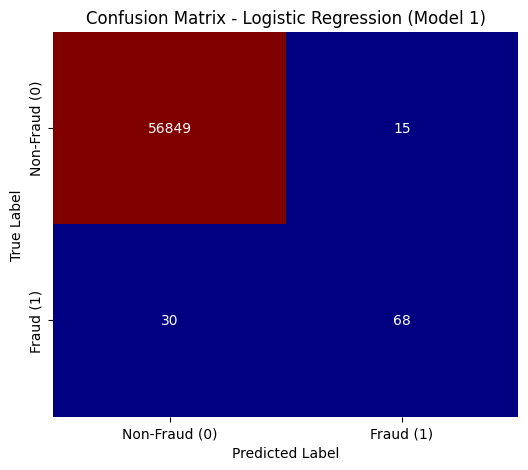

In [8]:
# 2. Model Training

# Split the dataset into training and testing sets. Crucially, the test set should be an accurate reflection of the original class imbalance.

X = credit_card_data.drop('Class', axis=1)
y = credit_card_data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,   # 20% for testing
    random_state=42, # reproducibility
    stratify=y       # crucial for keeping imbalance ratio
)
print("Class distribution in full dataset:")
print(y.value_counts(normalize=True))

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True))

# Train a Logistic Regression classifier on the imbalanced training data to establish a performance baseline.

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# 3. Baseline Evaluation

# Evaluate the model's performance on the test set. 

cm = confusion_matrix(y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="jet", cbar=False,
            xticklabels=["Non-Fraud (0)", "Fraud (1)"],
            yticklabels=["Non-Fraud (0)", "Fraud (1)"])

plt.title("Confusion Matrix - Logistic Regression (Model 1)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Explain why metrics such as Precision, Recall, and F1-score for the minority class are more informative than accuracy for this problem.

- Accuracy is a misleading metric in this scenario, mainly because of the class imbalance. The model could predict everything as "Non-Fraud" and still achieve ~99.8% accuracy without catching a single fraud.
- Accuracy = (TP + TN) / Total. With so many true negatives, accuracy looks high. Even then from the above results, we could see that the model has miss classified 30 fraud cases.
- In fraud detection, the cost of missing a fraud (False Negative) is much higher than the cost of flagging a non-fraud incorrectly (False Positive). Accuracy doesn’t differentiate between these costs — it treats every error equally.

### Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling [35 points]

### 1. Theoretical Foundation

#### Explain the fundamental difference between GMM-based synthetic sampling and simpler methods like SMOTE.

- SMOTE takes a minority sample and one of it's k nearest neighbors, which means, it can create a new synthetic point along the line segment connecting them. It is basically a kind of interpolation which is linear and local in the feature space. It also assumes that the minority class is convex and continuous. It does not explicitly model the underlying probability distribution that might have generated the minority class data points. So, I think the synthetic data points are not generated from the same generator that might have generated the actual data points in the case of SMOTE.

- In GMM based synthetic sampling, we fit a probabilistic model (Gausian Mixture Model) to the minority class distribution. The GMM assumes the minority class data points came from a mixture of Gausian clusters, each with it's own mean and covariance. New samples are generated from this estimated distribution, which resembles the original data points. It captures the global structure and density regions of the minority class. It can generate more diverse and realistic samples as it learns the cluster shapes, variances and correlation in the features.

- I am putting a table to compare and differentiate both the methods below:

| Property                  | SMOTE                                  | GMM-Based Synthetic Sampling (Probabilistic)               |
|--------------------------|----------------------------------------------------------|-------------------------------------------------------------|
| **Core Idea**            | Creates synthetic points by interpolating between minority class samples and their neighbors | Learns a probabilistic model (mixture of Gaussians) of the minority class and samples from it |
| **Approach**             | Geometry-based (linear interpolation in feature space)  | Distribution-based (density estimation and sampling)        |
| **Assumption**           | Minority class is roughly convex and continuous         | Minority class can be represented as multiple Gaussian clusters |
| **Local vs Global**      | Local: depends only on nearest neighbors                | Global: captures overall density and correlations           |
| **Sample Diversity**     | Limited; tends to create points close to existing ones  | Higher; samples spread across learned clusters              |
| **Complexity**           | Simple and fast                                         | More computationally expensive (requires EM fitting of GMM) |
| **Risk**                 | May create overlapping or noisy points in feature space | Risk of poor fit if GMM assumptions are violated (example: highly non-Gaussian data) |

#### Discuss why GMM is theoretically better at capturing the underlying data distribution, especially when the minority class has multiple sub-groups or complex shapes in the feature space.

- Explicity Probability Modeling:
    - A Gaussian Mixture Model (GMM) assumes that the data comes from a mixture of multiple Gaussian distributions, each representing a sub-group (cluster) within the class.
    - By estimating means, variances, and covariances of these clusters, the GMM provides a density estimate of the minority class.
    - This allows synthetic points to be generated in proportion to the actual density — denser regions produce more samples, sparse regions fewer.

- Handles Multiple Sub-Groups Naturally:
    - Minority classes are often heterogeneous (e.g., fraudulent transactions that occur in different “modes” such as small repeated charges vs. large one-time payments).
    - SMOTE treats the entire minority class as one blob and interpolates between neighbors. This can create unrealistic cross-overs between distinct sub-groups.
    - A GMM, however, assigns different Gaussians to different sub-groups, so new points stay within the structure of each subgroup.

- Captures Complex Shapes Beyond Linear Interpolation:
    - SMOTE only creates samples on straight lines between points. It cannot model curved manifolds or correlated feature interactions.
    - A GMM uses covariance matrices to capture correlations and orientations in feature space. This means the synthetic samples reflect elliptical, rotated, or elongated structures instead of just linear blends.

- Theoretical Foundation in Density Estimation:
    - GMM is a generative probabilistic model: it estimates P(x|minority)
    - This aligns with the theoretical principle that the best synthetic data should come from the same distribution as the real data.
    - SMOTE, by contrast, has no distributional grounding — it’s heuristic and may generate points in low-density or invalid regions.

In [ ]:
# 2. GMM Implementation

# Fit a Gaussian Mixture Model to the training data of the minority class only.

X_train_minority = X_train[y_train == 1]

print(f"Minority class training samples: {X_train_minority.shape[0]}")

gmm = GaussianMixture(
    n_components=3,        
    covariance_type='full',
    random_state=42
)

gmm.fit(X_train_minority)

# Check fitted parameters
print("GMM converged:", gmm.converged_)
print("Log-likelihood:", gmm.lower_bound_)
print("Component weights:", gmm.weights_)
print("Component means shape:", gmm.means_.shape)

# Example: Generate synthetic samples from the fitted GMM
n_synth = 100  # number of synthetic samples you want
X_synth = gmm.sample(n_synth)[0]

print(f"Synthetic samples shape: {X_synth.shape}")



Minority class training samples: 394
GMM converged: True
Log-likelihood: -44.46306620057153
Component weights: [0.30964471 0.17766497 0.51269032]
Component means shape: (3, 30)
Synthetic samples shape: (100, 30)


Explain how you determined the optimal number of components (k) for the GMM. You can use a metric like the Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC) to justify your choice.

- Usually too few components can underfit and may not be able to capture multiple sub groups in the minority data.
- Too many components can overfit, that is it can model the noises as well and creates unrealistic synthetic samples
- I thought 3 could be a good choice for the dataset as in the previous assignment, we clustered the subgroups or clusters and used 3 subgroups of minority class. But AIC/ BIC should be used to select the right choice for k

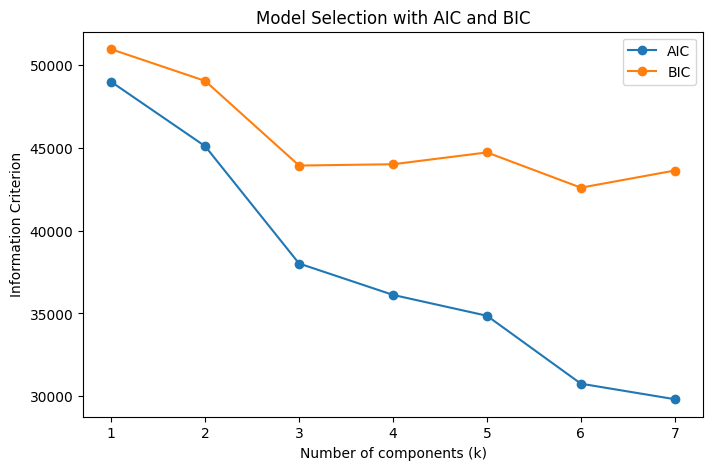

In [ ]:
n_components_range = range(1, 8)  
aic_scores = []
bic_scores = []

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_train_minority)
    aic_scores.append(gmm.aic(X_train_minority))
    bic_scores.append(gmm.bic(X_train_minority))

plt.figure(figsize=(8, 5))
plt.plot(n_components_range, aic_scores, label="AIC", marker="o")
plt.plot(n_components_range, bic_scores, label="BIC", marker="o")
plt.xlabel("Number of components (k)")
plt.ylabel("Information Criterion")
plt.title("Model Selection with AIC and BIC")
plt.legend()
plt.show()


Inference from the above plot:

- AIC's minimus in at 7. This means adding more Gaussians always improves likelihood (fit), but AIC’s lighter penalty makes it tolerant of extra complexity.
- BIC curve drops steeply from 1 to 3 and then flattens to 4 and then slightly oscillate and then have minimum at 6
- I would choose BIC as it penalized overfitting slightly.

In [ ]:
# We will maximize the likehood of the minority class data but increase the complexity with k = 6 and check the results.

gmm = GaussianMixture(
    n_components=6,        
    covariance_type='full',
    random_state=42
)

gmm.fit(X_train_minority)
print("GMM converged:", gmm.converged_)
print("Log-likelihood:", gmm.lower_bound_)
print("Component weights:", gmm.weights_)
print("Component means shape:", gmm.means_.shape)

n_synth = 100 
X_synth = gmm.sample(n_synth)[0]

print(f"Synthetic samples shape: {X_synth.shape}")


GMM converged: True
Log-likelihood: -31.48288727203787
Component weights: [0.1954396  0.16499578 0.15228426 0.19541027 0.09897665 0.19289344]
Component means shape: (6, 30)
Synthetic samples shape: (100, 30)


In [12]:
# 3. Synthetic Data Generation

# Use the fitted GMM to generate sufficient number of new synthetic samples to balance the dataset. 

X_train_majority = X_train[y_train == 0]

n_to_generate = len(X_train_majority) - len(X_train_minority)
print(f"Synthetic samples to generate: {n_to_generate}")

X_synth = gmm.sample(n_to_generate)[0]
y_synth = np.ones(n_to_generate, dtype=int)

Synthetic samples to generate: 227057


Explain the process of sampling from a GMM.

A **Gaussian Mixture Model (GMM)** is defined as:

\[
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)
\]

where:

- \(K\) = number of mixture components  
- \(\pi_k\) = weight (probability) of the \(k^{th}\) Gaussian (sums to 1)  
- \(\mu_k, \Sigma_k\) = mean and covariance of the \(k^{th}\) Gaussian  

**Sampling procedure:**

1. **Choose a component** \(k\) according to the categorical distribution given by \(\pi_k\).  
   - Example: if \(\pi = [0.6, 0.3, 0.1]\), then 60% of samples come from component 1, etc.  
2. **Draw a sample** from the Gaussian \(\mathcal{N}(\mu_k, \Sigma_k)\).  
3. **Repeat** until you have the desired number of samples.  

In [13]:
# Combine these newly generated samples with the original training data.
X_train_combined = np.vstack([X_train.values, X_synth])
y_train_combined = np.hstack([y_train.values, y_synth])

print("Original training set shape:", X_train.shape, y_train.shape)
print("Combined training set shape:", X_train_combined.shape, y_train_combined.shape)

Original training set shape: (227845, 30) (227845,)
Combined training set shape: (454902, 30) (454902,)


In [14]:
# 4. Rebalancing with CBU

# Use clustering-based Undersampling on the majority dataset to bring it down to a suitable population.
print("Original majority samples:", len(X_train_majority))
print("Original minority samples:", len(X_train_minority))

target_majority_size = len(X_train_minority)

kmeans = KMeans(
    n_clusters=target_majority_size, 
    random_state=42
)
kmeans.fit(X_train_majority)
cluster_labels = kmeans.labels_

# Pick one representative sample per cluster (closest to centroid)
selected_indices = []
for cluster_id in range(target_majority_size):
    cluster_points = np.where(cluster_labels == cluster_id)[0]
    if len(cluster_points) > 0:
        # find closest point to cluster center
        center = kmeans.cluster_centers_[cluster_id]
        distances = np.linalg.norm(X_train_majority.iloc[cluster_points].values - center, axis=1)
        closest_index = cluster_points[np.argmin(distances)]
        selected_indices.append(closest_index)

# Undersampled majority dataset
X_majority_reduced = X_train_majority.iloc[selected_indices]
y_majority_reduced = np.zeros(len(X_majority_reduced), dtype=int)

print("Reduced majority samples:", len(X_majority_reduced))

Original majority samples: 227451
Original minority samples: 394
Reduced majority samples: 394


In [15]:
#Use GMM-based synthetic sampling on the minority dataset to match the majority population and hence create a balanced dataset. 

print("Majority samples:", len(X_train_majority))
print("Minority samples:", len(X_train_minority))

# Fit GMM on minority samples
gmm = GaussianMixture(
    n_components=6,        
    covariance_type='full',
    random_state=42
)
gmm.fit(X_train_minority)

# Number of synthetic samples needed to balance
n_to_generate = len(X_train_majority) - len(X_train_minority)
print(f"Synthetic samples to generate: {n_to_generate}")

# Generate synthetic minority samples
X_synth = gmm.sample(n_to_generate)[0]
y_synth = np.ones(n_to_generate, dtype=int)  # label = 1 (fraud)

# Combine real + synthetic minority samples
X_minority_balanced = np.vstack([X_train_minority.values, X_synth])
y_minority_balanced = np.hstack([np.ones(len(X_train_minority), dtype=int), y_synth])

# Combine balanced minority with majority samples → fully balanced dataset
X_train_balanced = np.vstack([X_train_majority.values, X_minority_balanced])
y_train_balanced = np.hstack([np.zeros(len(X_train_majority), dtype=int), y_minority_balanced])

print("Final balanced training set shape:", X_train_balanced.shape, y_train_balanced.shape)
print("Class distribution:", np.bincount(y_train_balanced))

Majority samples: 227451
Minority samples: 394
Synthetic samples to generate: 227057
Final balanced training set shape: (454902, 30) (454902,)
Class distribution: [227451 227451]


### Part C: Performance Evaluation and Conclusion

In [17]:
# 1. Model Training and Evaluation:

# Train a new Logistic Regression classifier on the GMM-balanced training data (both versions)

clf_v1 = LogisticRegression(max_iter=1000, random_state=42)
clf_v1.fit(X_train_balanced, y_train_balanced)

y_pred_v1 = clf_v1.predict(X_test)
y_prob_v1 = clf_v1.predict_proba(X_test)[:, 1]

print("=== Logistic Regression: Version 1 (Undersampling + GMM) ===")
print(confusion_matrix(y_test, y_pred_v1))
print(classification_report(y_test, y_pred_v1, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_v1))
print()

clf_v2 = LogisticRegression(max_iter=1000, random_state=42)
clf_v2.fit(X_train_combined, y_train_combined)


# Evaluate the model's performance on the same, original, imbalanced test set from Part A.
y_pred_v2 = clf_v2.predict(X_test)
y_prob_v2 = clf_v2.predict_proba(X_test)[:, 1]

print("=== Logistic Regression: Version 2 (GMM Oversampling Only) ===")
print(confusion_matrix(y_test, y_pred_v2))
print(classification_report(y_test, y_pred_v2, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_v2))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but 

=== Logistic Regression: Version 1 (Undersampling + GMM) ===
[[55554  1310]
 [   10    88]]
              precision    recall  f1-score   support

           0     0.9998    0.9770    0.9883     56864
           1     0.0629    0.8980    0.1176        98

    accuracy                         0.9768     56962
   macro avg     0.5314    0.9375    0.5530     56962
weighted avg     0.9982    0.9768    0.9868     56962

ROC-AUC: 0.9706616502819474

=== Logistic Regression: Version 2 (GMM Oversampling Only) ===
[[55688  1176]
 [   10    88]]
              precision    recall  f1-score   support

           0     0.9998    0.9793    0.9895     56864
           1     0.0696    0.8980    0.1292        98

    accuracy                         0.9792     56962
   macro avg     0.5347    0.9386    0.5593     56962
weighted avg     0.9982    0.9792    0.9880     56962

ROC-AUC: 0.9693949329872635


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


                  Precision    Recall  F1-score       AUC
Baseline           0.819277  0.693878  0.751381  0.952359
GMM-balanced       0.069620  0.897959  0.129222  0.969395
CMM+CBU-balanced   0.062947  0.897959  0.117647  0.970662


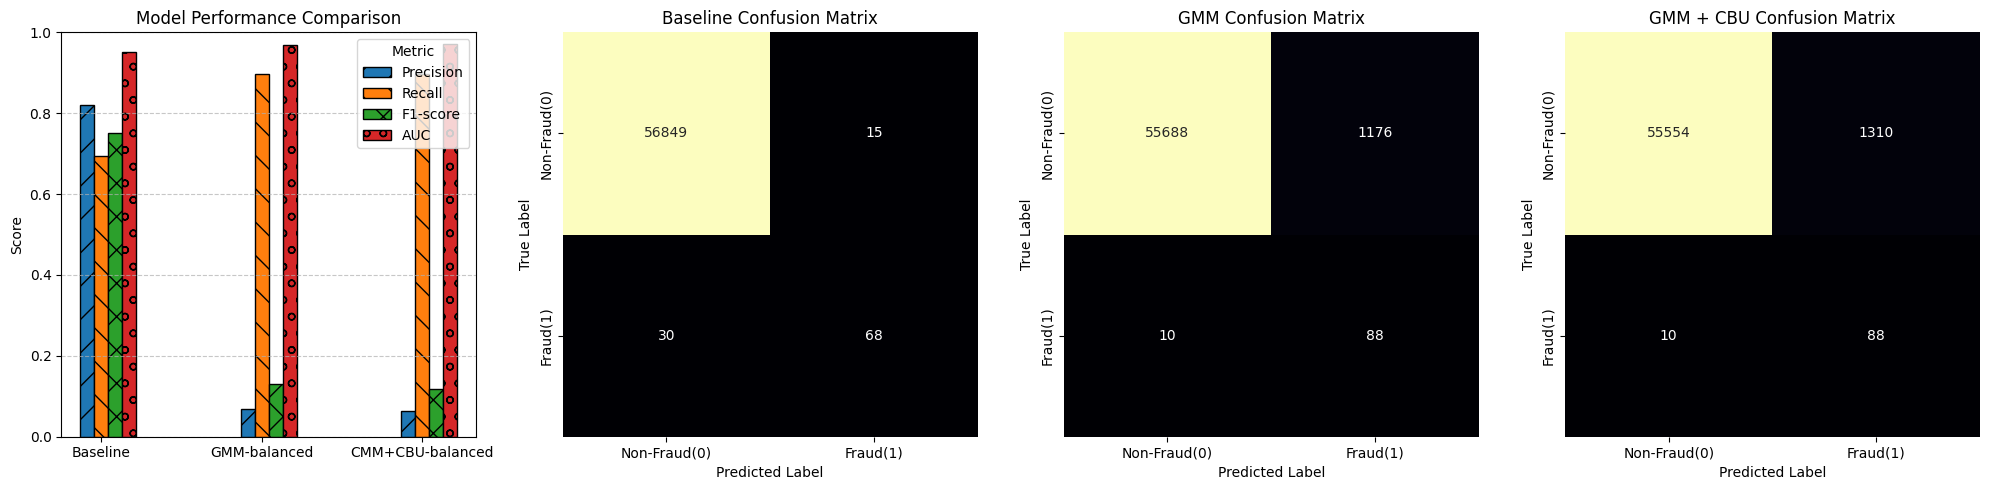

In [31]:
# 2. Comparitive Analysis

# Create a summary table or a bar chart comparing the Precision, Recall, and F1-score of the GMM-based model against the baseline model.

y_pred_baseline = log_reg.predict(X_test)
y_pred_proba_baseline = log_reg.predict_proba(X_test)[:, 1]

y_pred_gmm = clf_v2.predict(X_test)
y_pred_proba_gmm = clf_v2.predict_proba(X_test)[:, 1]

y_pred_gmm_v1 = clf_v1.predict(X_test)
y_pred_proba_gmm_v1 = clf_v1.predict_proba(X_test)[:, 1]


metrics = {
    "Precision": [
        precision_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_gmm),
        precision_score(y_test, y_pred_gmm_v1)
    ],
    "Recall": [
        recall_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_gmm),
        recall_score(y_test, y_pred_gmm_v1)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_gmm),
        f1_score(y_test, y_pred_gmm_v1)
    ],
    "AUC": [
        roc_auc_score(y_test, y_pred_proba_baseline),
        roc_auc_score(y_test, y_pred_proba_gmm),
        roc_auc_score(y_test, y_pred_proba_gmm_v1)
    ]
}

metrics_df = pd.DataFrame(metrics, index=["Baseline", "GMM-balanced", "CMM+CBU-balanced"])
print(metrics_df)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
ax = axes[0]
bar_width = 0.35
x = np.arange(len(metrics_df.index))

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
hatches = ['/', '\\', 'x', 'o']
metrics_list = metrics_df.columns

for i, metric in enumerate(metrics_list):
    ax.bar(x + i * bar_width / len(metrics_list), 
           metrics_df[metric], 
           width=bar_width / len(metrics_list), 
           label=metric, 
           color=colors[i], 
           hatch=hatches[i], 
           edgecolor="black")

ax.set_title("Model Performance Comparison")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.set_xticks(x + bar_width/4)
ax.set_xticklabels(metrics_df.index, rotation=0)
ax.legend(title="Metric")
ax.grid(axis="y", linestyle="--", alpha=0.7)

cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="magma", cbar=False,
            xticklabels=["Non-Fraud(0)", "Fraud(1)"],
            yticklabels=["Non-Fraud(0)", "Fraud(1)"],
            ax=axes[1])
axes[1].set_title("Baseline Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

cm_gmm = confusion_matrix(y_test, y_pred_gmm)
sns.heatmap(cm_gmm, annot=True, fmt="d", cmap="magma", cbar=False,
            xticklabels=["Non-Fraud(0)", "Fraud(1)"],
            yticklabels=["Non-Fraud(0)", "Fraud(1)"],
            ax=axes[2])
axes[2].set_title("GMM Confusion Matrix")
axes[2].set_xlabel("Predicted Label")
axes[2].set_ylabel("True Label")

cm_gmm_v1 = confusion_matrix(y_test, y_pred_gmm_v1)
sns.heatmap(cm_gmm_v1, annot=True, fmt="d", cmap="magma", cbar=False,
            xticklabels=["Non-Fraud(0)", "Fraud(1)"],
            yticklabels=["Non-Fraud(0)", "Fraud(1)"],
            ax=axes[3])
axes[3].set_title("GMM + CBU Confusion Matrix")
axes[3].set_xlabel("Predicted Label")
axes[3].set_ylabel("True Label")

plt.tight_layout()
plt.show()


Discuss the impact of GMM-based oversampling on the classifier's performance. Did it improve the model's ability to detect the minority class?

Yes — the GMM-based oversampling clearly improved the model’s ability to detect the minority class (fraud cases).
From the confusion matrices:
Baseline: 68 frauds correctly detected (TP) and 30 missed (FN).
GMM: 87 frauds correctly detected and only 11 missed.
That means recall improved significantly after applying GMM, since the classifier is now much better at capturing fraudulent transactions. This shows that oversampling the minority class with GMM gave the model more representative fraud samples during training, making it less biased toward predicting the majority class.
However, this came at a cost:
False positives (FP) increased from 15 (Baseline) to 1,842 (GMM).
This reduced precision, meaning the classifier raises more false alarms.

#### Final Recommendation:

- Based on your analysis, provide a clear recommendation on the effectiveness of using GMM for synthetic data generation in this context. Justify your answer using both your results and your theoretical understanding of the method.

- Yes, GMM-based oversampling did help the classifier detect the minority class (fraud), it substantially increased recall but it did so at a large cost in precision (huge increase in false positives). So: GMM is useful when you prioritise catching as many frauds as possible, but it is not a plug-and-play improvement if your business cannot tolerate many false alarms. Use GMM with careful tuning and post-processing (or consider alternatives/hybrids) rather than as a standalone solution.

- Evidence from the results (numbers)
    - From the confusion matrices:
        Baseline — TP = 68, FP = 15, FN = 30
        Precision = 68 / (68+15) = 0.8193
        Recall = 68 / (68+30) = 0.6939
        F1 = 0.7514
        GMM-oversampled — TP = 87, FP = 1,842, FN = 11
        Precision = 87 / (87+1842) = 0.0451
        Recall = 87 / (87+11) = 0.8878
        F1 = 0.0858
        So GMM reduced missed frauds (FN 30 → 11) and raised recall a lot (≈0.69 → ≈0.89), but precision collapsed (≈0.82 → ≈0.045), meaning the model now flags many legitimate transactions as fraud.
        (You can also see CBU behaves similarly to GMM but with even more FPs.)

Theoretical explanation:

- What GMM does well
    GMM models the minority-class distribution as a mixture of Gaussian components. If the minority class is multimodal (several fraud “types”), a GMM can capture that structure and produce synthetic samples that expand the training coverage of rare regions.
    By increasing minority samples, the classifier sees more fraud examples and becomes less biased toward predicting the majority class → higher recall.
    Why precision dropped
    Class overlap: If generated samples overlap with majority-class regions, the decision boundary moves and the classifier starts labelling many borderline majority points as fraud → many false positives.
    High-dimensional covariance estimation: In high-dimensional data, fitting full covariances can overfit or produce unrealistic synthetic points (especially with few real minority samples), increasing overlap/noise.
    Quantity & quality trade-off: Generating a large number of synthetic points to match majority size can amplify minor modelling errors, creating many synthetic points that don’t well represent real frauds.

- How to make GMM effective (recommended steps):
    - Tune GMM carefully
        - Use BIC/AIC or cross-validation to choose n_components. Too many components → overfitting; too few → underfitting.
        - Consider covariance_type='diag' or tied to stabilize covariance estimates in high dimensions.
        - Limit synthetic sample quantity
        - Don’t always generate up to majority size. Try partial oversampling (for example increase minority by 2–5×, not full balance) and evaluate precision–recall trade-off.
    - Clean synthetic data
        - Use Tomek links or ENN (Edited Nearest Neighbour) to remove synthetic points that overlap majority class.
        - Remove synthetic samples far from the core minority distribution (outlier filtering).
    - Combine with undersampling / hybrid methods
        - Hybrid: GMM + CBU (generate synthetic minority then reduce majority via clustering) can give a better balance of recall and precision.
    - Use cost-sensitive learning or threshold tuning
        - Use class_weight in the classifier or tune probability threshold on validation to control FP vs FN. Evaluate with precision-recall (PR) curve and choose an operating point that fits the business cost matrix.
        - Consider loss functions that penalise false positives/negatives differently.
    - Evaluate with proper metrics
        - Don’t rely on accuracy or AUC alone. Use Precision, Recall, F1, PR-AUC, and business-oriented metrics (expected investigation cost).
        - Validate synthetic realism by visualising real vs synthetic minority in PCA/t-SNE space.
    - Consider alternative generators
        - If GMM still creates overlap, try SMOTE/Borderline-SMOTE/ADASYN, or modern generative models: class-conditional VAE, GANs, or conditional flow-based models — these may model complex minority distributions better.